### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 5th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

Text(0, 0.5, 'Time')

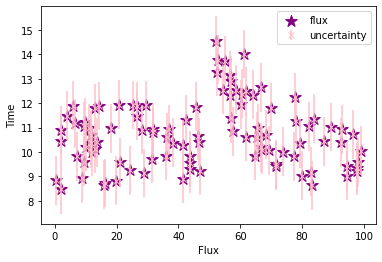

In [51]:
# 1) Read in hw5_data_1.npy. This is a (10 x 3) numpy array, containing some time-series measurements. It could 
#be flux measurements from a star or some other transient. The first column is time (arbitrary units), the 
#second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties 
#on the flux. Plot this data with the uncertainties.

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

data = np.load('../../../../coursework/homeworks/hw_data/hw5_data_1.npy') #reading data
time = data[:,0] #time
flux = data[:,1] #flux
u = data[:,2] #homoscedastic measurement uncertainties  on flux

#print(time)

plt.scatter(time,flux,s=150,marker='*',c='purple',label='flux')
plt.errorbar(time,flux,yerr=u,ls=' ',marker='x',color='pink',label='uncertainty')
plt.legend()
plt.xlabel('Flux')
plt.ylabel('Time')

In [2]:
# 2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background
#level. This model can be described as:
#𝑦=𝑏, for 𝑡<𝑡0
#𝑦=𝑏+𝐴exp[−𝛼(𝑡−𝑡0)], for 𝑡≥𝑡0
#where 𝑏 is the background amplitude, 𝐴 is the burst amplitude, 𝑡0 is the burst epoch, and 𝛼 encodes how rapidly 
#the burst dies off. Code this burst model, and code a likelihood function for this data with the burst model. 
#Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now 𝑥 is time, and 
#the polynomial model is now the burst model.
#b is background amplitude, A is burst amplitude, t0 is burst epoch, alpha how fast burst dies off

def burst(b,t,t0,A,alpha): #defining burst model
    ymodel = np.full(len(t),0) #empty array
    idtlt0 = np.where(np.array(t)<t0)[0] #index when t is less than t0
    idtgt0 = np.where(np.array(t)>=t0)[0] #index when t is greater than or equal to t0
    ymodel[idtlt0] = b #populating array with idtlt0
    ymodel[idtgt0] = b + A*(np.exp(-alpha*(np.array(t[idtgt0])-t0))) #populating array with idtgt0
    return ymodel

def logL(theta): #defining log likelihood function
    y_fit = burst(b=theta[0],t=time,t0=theta[1],A=theta[2],alpha=np.exp(theta[3])) 
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(flux, y_fit, u)) 

In [3]:
#3) Using one of the MCMC codes that we looked at in class (emcee, pymc3, PTMCMCSampler) perform a Bayesian 
#analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of 
#{𝑏,𝐴,𝑡0,𝛼}. You must decide on how many samples are appropriate for running your MCMC. For your priors, make 
#them 𝑏∈Uniform[0,50], 𝐴∈Uniform[0,50], 𝑡0∈Uniform[0,100], and ln𝛼∈Uniform[−5,5].
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform


def logPrior(theta): #defining log prior function 
    bprior = stats.uniform.pdf(theta[0],loc=0,scale=50) #stats.uniform.pdf(a,b)->scale=a & loc+scale=b >scale = 50-0
    t0prior = stats.uniform.pdf(theta[1],loc=0,scale=100)
    Aprior = stats.uniform.pdf(theta[2],loc=0,scale=50)
    alphaprior = stats.uniform.pdf(theta[3],loc=-5,scale=10)
    return np.log(bprior*Aprior*t0prior*alphaprior) #alpha in log likelihood is exp(alpha) so we can multiply its prior with the rest

# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, outDir='./my_ptmcmc_chain', resume=False)

# sampler for N steps
N = int(10e5) #tested with N=3e4, N=3e5 until reaching N=10e5
x0 = np.array([10.,10.,45.,-1.]) #theta[0], theta[1], theta[2], theta[3] guesses #b=10,A=10,t0=45,logalpha=-1
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

Optional mpi4py package is not installed.  MPI support is not available.
Finished 0.10 percent in 8.097851 s Acceptance rate = 0.667

/tmp/ipykernel_12468/2596563450.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(bprior*Aprior*t0prior*alphaprior)


Finished 1.00 percent in 64.330456 s Acceptance rate = 0.390633Adding DE jump with weight 50
Finished 99.90 percent in 7627.038664 s Acceptance rate = 0.147766
Run Complete


Taking every n = 211 samples based on ac length.
Burning first n = 24975 samples.


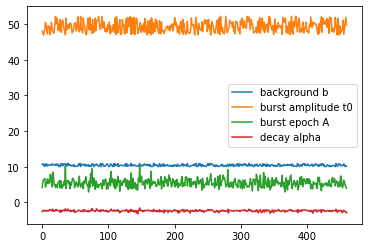

In [68]:
#4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every 
#auto-correlation length. If you are left with a small number of samples after thinning then you may need to run 
#your MCMC for longer in (3).

import acor

#I plotted the chain without any cuts and took into account when the chain seems to settle down and it was
#after around ~2000 samples, so I chose 3000 for a bit more safety
l2 = 3000 

thin = int(acor.acor(chain[:,0])[0]) #autocorrelation length (acor.acor)
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(l) + ' samples.')

#plotting without any cuts to the chain
# plt.plot(chain[:,0],label='background b');
# plt.plot(chain[:,1],label='burst amplitude t0');
# plt.plot(chain[:,2],label='burst epoch A');
# plt.plot(chain[:,3],label='decay alpha');
# plt.xlim(0,10000)
# plt.legend()

#plotting down sampled chain
plt.plot(chain[l2::thin,0],label='background b');
plt.plot(chain[l2::thin,1],label='burst amplitude t0');
plt.plot(chain[l2::thin,2],label='burst epoch A');
plt.plot(chain[l2::thin,3],label='decay alpha');
#plt.xlim(0,8000)
plt.legend()

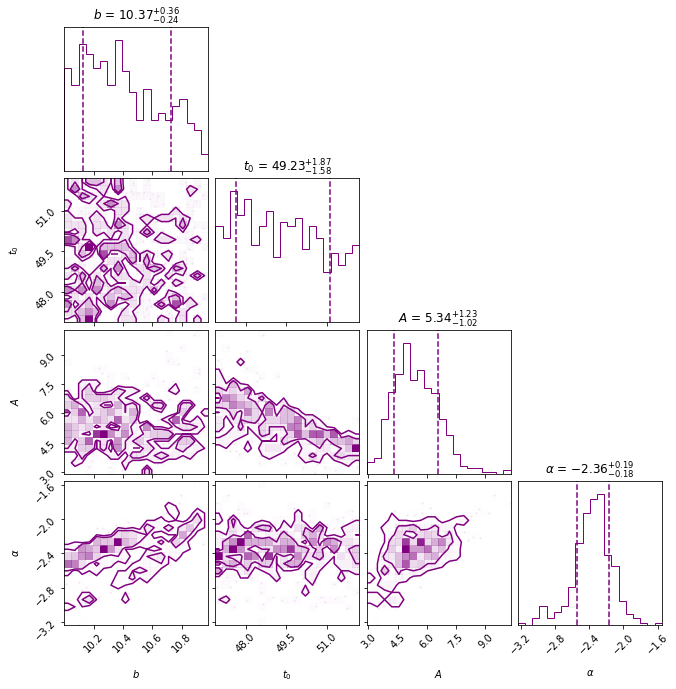

In [69]:
#5) Make a corner plot of the 4-D parameter space, with labels, [68,95]% credible levels and quantiles, and 
#titles.

import corner

ds1 = chain[l2::thin,0] #b #down sampling
ds2 = chain[l2::thin,1] #t0
ds3 = chain[l2::thin,2] #A
ds4 = chain[l2::thin,3] #alpha

lls = np.array([ds1, ds2, ds3, ds4])
fig = corner.corner(lls.T,quantiles=(0.16,0.84),levels=(0.68,0.95),labels=[r'$b$',r'$t_{0}$',r'$A$',r'$\alpha$'],color='purple',show_titles=True)

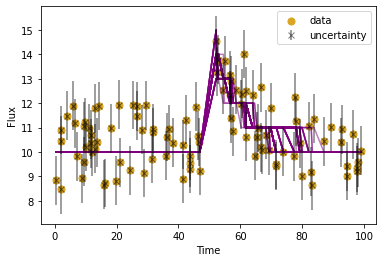

In [71]:
#6) Now choose 100 samples randomly from your burned, thinned chain and plot the 100 corresponding burst 
#time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst 
#curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that 
#are consistent with the data.

rand_idx = np.random.randint(0,len(ds1),size=100,dtype=int) # 100 random indexes from 0 to len(down samples)

for i in rand_idx:
    b100 = ds1[i] 
    t0100 = ds2[i] 
    A100 = ds3[i] 
    alpha100 = ds4[i] 
    burst_eq = burst(b100,time,t0100,A100,np.exp(alpha100))
    plt.plot(time,burst_eq,alpha=0.5,color='purple')

plt.errorbar(time,flux,yerr=u,ls=' ',marker='x',color='black',label='uncertainty',alpha=0.5)
plt.scatter(time,flux,c='goldenrod',marker='o',s=50,label='data')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.legend()

#extra comments:
#Im not really sure why the curve doesnt look smooth. It could be from the number of samples to perhaps
#my burst function? Perhaps the number of samples after down sampling was too small which lead to higher
#unnacuracies? maybe I didn't code my function in the most optimal way? 

In [75]:
# 7) Another possible model that may explain the data is a Gaussian profile described by: 𝑦=𝑏+𝐴exp[−(𝑡−𝑡0)2/2𝜎2𝑊]
#The priors for this model are the same as above for the equivalent parameters, and with ln𝜎𝑊∈Uniform[−2,2]. 
#Following the examples from Lecture 12 and from relevant web tutorials/documentation, use one of the nested 
#sampling packages (dynesty or UltraNest) to compute the Bayesian evidence for this Gaussian model, and for the 
#original burst model. Compute the Bayes factor, and state which model is the favored description of the data. 
#Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling 
#priors. An appropriate check on whether you have done things correctly is that the posterior samples you get 
#from the burst analysis here should give an equivalent corner plot to the MCMC you did above.

## NEST SAMPLING FOR GAUSSIAN MODEL ##

import dynesty

def gaussm(b,t,t0,A,sigmaW): #gaussian model function
    y = b + A*(np.exp((-(np.array(t)-t0)**2)/(2*sigmaW**2)))
    return np.array(y)

def logLG(theta): #log likelihood of gaussian model
    """Gaussian log-likelihood of the model at theta"""
    yfit = gaussm(b=theta[0],t=time,t0=theta[1],A=theta[2],sigmaW=np.exp(theta[3])) #exp sigmaW
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(flux, yfit, u)) 

def logPG(u_u): #prior function for gaussian model to use with dynesty
    params = u_u.copy()
    params[0] = u_u[0]*50 #(a,b) -> scale=a and loc+scale=b > scale = 50-0
    params[1] = u_u[1]*100
    params[2] = u_u[2]*50
    params[3] = 2. * (2. * u_u[3] - 1.)
    return params

#nested sampling.
sampler1 = dynesty.NestedSampler(logLG, logPG, 4)
sampler1.run_nested()
sresults1 = sampler1.results

iter: 7947 | +500 | bound: 33 | nc: 1 | ncall: 41700 | eff(%): 20.257 | loglstar:   -inf < -144.326 <    inf | logz: -159.487 +/-  0.245 | dlogz:  0.001 >  0.509                                     

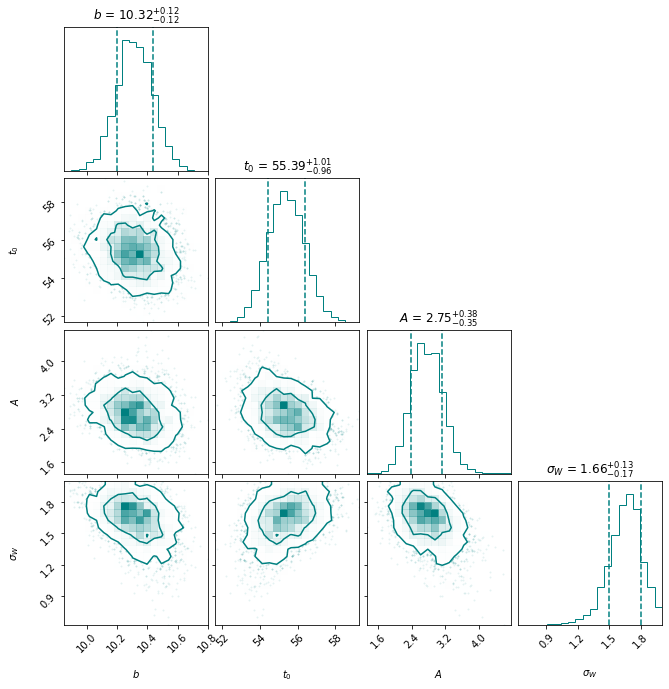

In [80]:
## NEST SAMPLING FOR GAUSSIAN MODEL ##

#Extract sampling results.
samples1 = sresults1.samples  # samples
weights1 = np.exp(sresults1.logwt - sresults1.logz[-1])  # normalized weights

#Resample weighted samples.
samples_equal1 = dyfunc.resample_equal(samples1, weights1)

#Plotting
_ = corner.corner(samples_equal1,quantiles=(0.16,0.84),levels=(0.68,0.95),labels=[r'$b$',r'$t_{0}$',r'$A$',r'$\sigma_W$'],color='teal',show_titles=True)

In [77]:
## NESTED SAMPLING FOR BURST MODEL ##

def logPb(ub): #prior function with the same parameters as before, but compatible for dynesty to use
    paramsb = ub.copy()
    paramsb[0] = ub[0]*50 #(a,b) -> scale=a and loc+scale=b > scale = 50-0
    paramsb[1] = ub[1]*100
    paramsb[2] = ub[2]*50
    paramsb[3] = 5. * (2. * ub[3] - 1.)
    return paramsb

#nested sampling
sampler2 = dynesty.NestedSampler(logL, logPb, 4)
sampler2.run_nested()
sresults2 = sampler2.results

iter: 7802 | +500 | bound: 91 | nc: 1 | ncall: 86405 | eff(%):  9.608 | loglstar:   -inf < -140.646 <    inf | logz: -155.570 +/-  0.253 | dlogz:  0.001 >  0.509                                     

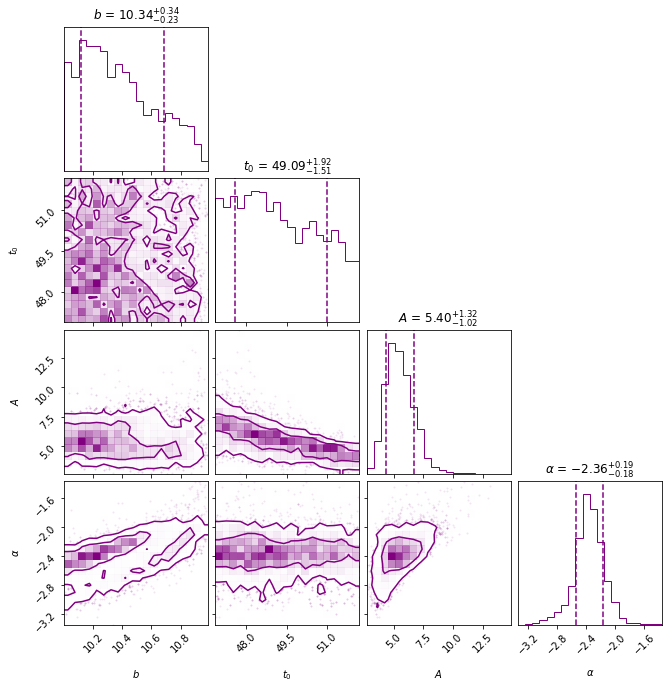

In [79]:
## NESTED SAMPLING FOR BURST MODEL ##

#Extract sampling results.
samples2 = sresults2.samples  # samples
weights2 = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

#Resample weighted samples.
samples_equal2 = dyfunc.resample_equal(samples2, weights2)

#Plotting
_ = corner.corner(samples_equal2,quantiles=(0.16,0.84),levels=(0.68,0.95),labels=[r'$b$',r'$t_{0}$',r'$A$',r'$\alpha$'],color='purple',show_titles=True)

#extra comments:
#the values aren't exactly the same as the ones shown above for the burst model (also in purple). They are close,
#but not the exact same. Additionally, the plots look similar but again, not exactly the same.
#Not sure if I should expect them to be so, I don't think so? but I am not 100% sure.

In [90]:
#Calculating the posterior for the nested burst model

idss = np.random.randint(0,len(samples_equal2[:,0]),size=100,dtype=int)
th1 = np.array([samples_equal2[:,0][idss],samples_equal2[:,1][idss],samples_equal2[:,2][idss],samples_equal2[:,3][idss]])

p_b = []
for i in range(len(th1)):
    th = np.array([th1[0][i],th1[1][i],th1[2][i],th1[3][i]]) #thetas
    lnl = logL(th) #log likelihoods
    lnp = logPrior(th) #log priors
    posts = lnl + lnp # sum of logs =  posteriors
    p_b.append(posts)

p_b = np.array(p_b) 
    
post = np.sum(p_b) # sum of posteriors for burst model
print(post,'posterior for nested burst model')

-629.244512172867 posterior for nested burst model


In [91]:
#Calculating the posterior for the nested gaussian model

ids = np.random.randint(0,len(samples_equal1[:,0]),size=100,dtype=int)
th2 = np.array([samples_equal1[:,0][ids],samples_equal1[:,1][ids],samples_equal1[:,2][ids],samples_equal1[:,3][ids]])

p_b2 = []
for i in range(len(th2)):
    TH = np.array([th2[0][i],th2[1][i],th2[2][i],th2[3][i]]) #thetas
    LNL = logLG(TH) #log likelihoods
    LNP = logPG(TH) #log priors
    POSTS = LNL + LNP # sum of logs =  posteriors
    p_b2.append(POSTS)

p_b2 = np.array(p_b2)
    
post2 = np.sum(p_b2) # sum of posteriors for burst model
print(post2,'posterior for nested gaussian model')

22476.511526326736 posterior for nested gaussian model


In [92]:
Z = post/post2 #burst divided by gaussian model 
print(Z) #prefers the gaussian model :( 
#not sure if my burst model is just not very good like I said before? :(

-0.02799564832095198
